In [27]:
# Quick hack to fix local imports for the generated files
import os
import sys
module_path = os.path.abspath(os.path.join('../generated'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [52]:
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.style as mplstyle
# mplstyle.use('fast')

%matplotlib inline

In [29]:
import platform
import subprocess
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import OutbreakSim.Model.Model as gen_model
import OutbreakSim.Model.Vec2

In [30]:
synthetic_environments = {}

In [31]:
def load_reports(report_dir):
    with open(report_dir + "parameters.json") as f:
        parameters = json.load(f)
    with open(report_dir + "concluding.json") as f:
        concluding = json.load(f)
        
    intermediary = pd.read_csv(report_dir + "intermediary.csv")
    
    return (parameters, intermediary, concluding)

In [32]:
def load_synthetic_environment(data_file_path):
    global synthetic_environments
    if data_file_path in synthetic_environments:
        return synthetic_environments[data_file_path]
    
    data_file_path = Path(data_file_path)
    if not data_file_path.exists() and platform.system() == 'Linux':
        # Try to convert the path to a WSL path
        data_file_path = Path(subprocess.run(['wslpath', '-a', data_file_path], capture_output=True).stdout.decode().strip())
    buf = open(data_file_path, 'rb').read()
    model = gen_model.Model.GetRootAsModel(buf, 0)
    synthetic_environments[data_file_path] = model
    return model

In [33]:
def parse_reports(report_dir):
    parameters, intermediary, concluding = load_reports(report_dir)
    synth_env = load_synthetic_environment(concluding['synthetic_environment_path'])
    
    intermediary['day'] = intermediary['time_step'] / parameters['time_steps_per_day']
    intermediary = intermediary.set_index('day')
    intermediary.drop('time_step', axis='columns', inplace=True)
    intermediary.rename({
        'num_susceptible': 'Susceptible', 
        'num_exposed': 'Exposed', 
        'num_infectious': 'Infectious', 
        'num_recovered': 'Recovered'}, 
        axis='columns', inplace=True)
    
    return (synth_env, parameters, intermediary, concluding)

In [34]:
def calc_area(syth_env):
    bounds_min = synth_env.Bounds().Min(OutbreakSim.Model.Vec2.Vec2())
    bounds_max = synth_env.Bounds().Max(OutbreakSim.Model.Vec2.Vec2())
    
    return (bounds_max.X() - bounds_min.X()) * (bounds_max.Y() - bounds_min.Y())

def parse_end_stats(index_name, synth_env, parameters, concluding):    
    return pd.DataFrame.from_records([{
        'num_agents': synth_env.Agents().AgeLength(),
        'area': calc_area(synth_env),
        'total_exec_time': concluding['simulation_execution_time_in_secs'],
        'steps_per_day': parameters['time_steps_per_day'],
        'total_steps': concluding['total_time_steps'],
    }], index=[index_name])

In [35]:
def graph_infections(intermediary, title):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_ylabel('Number of People')
    ax.set_title(title)
    intermediary.plot(ax=ax)
    return fig

In [36]:
def load_iterations(report_dir, iteration_range):
    synth_envs = []
    parameters = []
    intermediaries = []
    concludings = []
    for i in iteration_range:
        try:
            synth_env, params, intermediary, concluding = parse_reports(f"{report_dir}/{i}/")
            parameters.append(params)
            intermediary['iteration'] = i
            intermediaries.append(intermediary)
            concludings.append(concluding)
        except:
            print(f'damn {i}')
        
    return (synth_envs, parameters, intermediaries, concludings)

In [37]:
colors = {'Susceptible': '#1f77b4', 'Exposed': '#ff7f0e', 'Infectious': '#d62728', 'Recovered': '#2ca02c'}

def graph_seir_iterations(intermediaries, fig, ax):
    if fig == None and ax == None:
        fig, ax = plt.subplots()
    
    for _, df in pd.concat(intermediaries).groupby('iteration'):
        df.drop('iteration', axis='columns').plot(ax=ax, legend=False, color=colors.values());
    ax.set_xlabel('Day')
    ax.set_ylabel('Number of People')
    
    by_label = {}
    for axis in fig.axes:
        for h,l in zip(*axis.get_legend_handles_labels()): # we don't want duplicate legend labels so group them
            by_label[l] = h
    for axis in fig.axes:
        if (axis.get_legend()): # we don't want duplicate legends so remove any already drawn
            axis.get_legend().remove()
    
        leg = axis.legend(by_label.values(), by_label.keys(), loc='upper right') # redraw a single legend on the axis
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    
    return fig, ax

In [38]:
def graph_mean_std_dev(intermediaries, fig, ax):
    if fig == None and ax == None:
        fig, ax = plt.subplots()
    concated = pd.concat(intermediaries).drop('iteration', axis='columns')
    mean = concated.groupby(concated.index).mean()
    std_dev = concated.groupby(concated.index).std()

    mean.plot(ax=ax, legend=False, color=[colors.get(col) for col in mean.columns])
    for col in ['Susceptible', 'Exposed', 'Infectious', 'Recovered']:
        ax.fill_between(std_dev.index, mean[col]+std_dev[col], mean[col]-std_dev[col], alpha=0.3, color=colors.get(col))
    
    by_label = {}
    for axis in fig.axes:
        for h,l in zip(*axis.get_legend_handles_labels()): # we don't want duplicate legend labels so group them
            by_label[l] = h
    for axis in fig.axes:
        if (axis.get_legend()): # we don't want duplicate legends so remove any already drawn
            axis.get_legend().remove()
    
        leg = axis.legend(by_label.values(), by_label.keys(), loc='upper right') # redraw a single legend on the axis
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
        
    ax.set_xlabel('Day')
    ax.set_ylabel('Number of People')
    
    return fig, ax

In [39]:
def graph_mean_min_max(intermediaries, fig, ax):
    if fig == None and ax == None:
        fig, ax = plt.subplots()
    concated = pd.concat(intermediaries).drop('iteration', axis='columns')
    mean = concated.groupby(concated.index).mean()
    max_bound = concated.groupby(concated.index).max()
    min_bound = concated.groupby(concated.index).min()

    mean.plot(ax=ax, legend=False, color=[colors.get(col) for col in mean.columns])
    max_bound.plot(ax=ax, legend=False, alpha=0.5, color=[colors.get(col) for col in max_bound.columns])
    min_bound.plot(ax=ax, legend=False, alpha=0.5, color=[colors.get(col) for col in min_bound.columns])
    
    by_label = {}
    for axis in fig.axes:
        for h,l in zip(*axis.get_legend_handles_labels()): # we don't want duplicate legend labels so group them
            by_label[l] = h
    for axis in fig.axes:
        if (axis.get_legend()): # we don't want duplicate legends so remove any already drawn
            axis.get_legend().remove()
    
        leg = axis.legend(by_label.values(), by_label.keys(), loc='upper right') # redraw a single legend on the axis
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
        
    ax.set_xlabel('Day')
    ax.set_ylabel('Number of People')
    
    return fig, ax

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='Day', ylabel='Number of People'>)

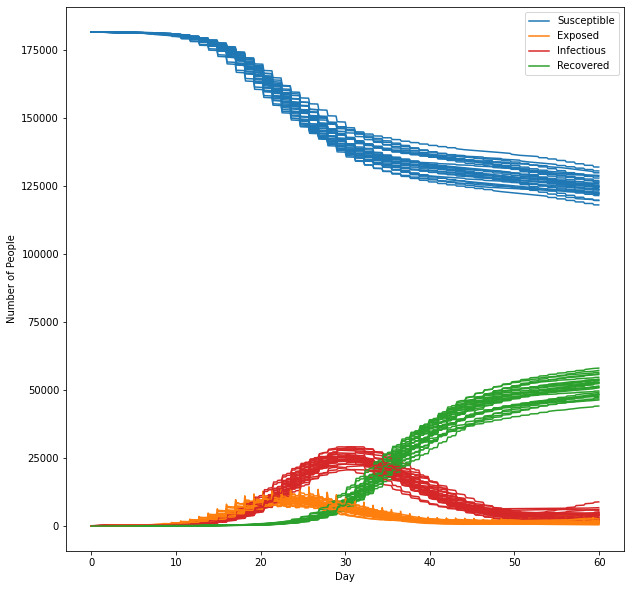

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/cambridge/", range(0, 30))
graph_seir_iterations(intermediaries, fig, ax)

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='Day', ylabel='Number of People'>)

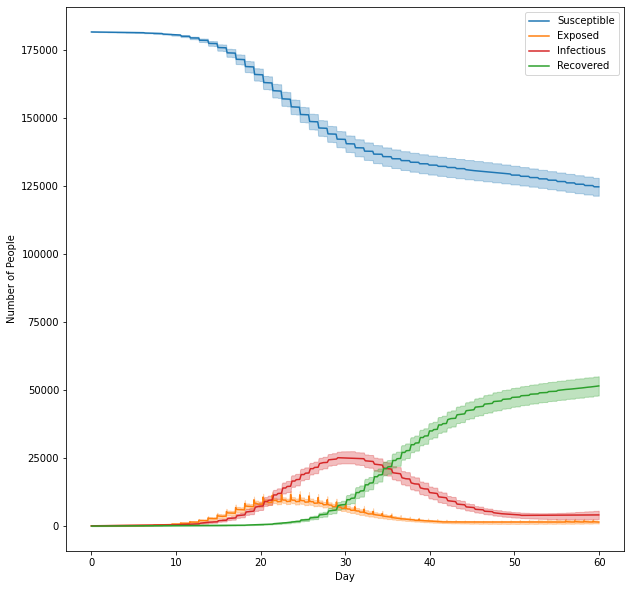

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/cambridge/", range(0, 30))
graph_mean_std_dev(intermediaries, fig, ax)

In [50]:
plt.show()

In [114]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(10,12))

In [115]:
%%time
for i in range(6):
    synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_45iter_180days_varic/isle_of_dogs/", range(i*45, (i+1)*45))
    graph_mean_std_dev(intermediaries, fig, ax1)
ax1.set_title("Isle of Dogs");

CPU times: user 2.64 s, sys: 1min 14s, total: 1min 16s
Wall time: 1min 18s


Text(0.5, 1.0, 'Isle of Dogs')

In [116]:
for i in range(6):
    synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_45iter_180days_varic/isle_of_wight/", range(i*45, (i+1)*45))
    graph_mean_std_dev(intermediaries, fig, ax2)
ax2.set_title("Isle of Wight");

Text(0.5, 1.0, 'Isle of Wight')

In [117]:
for i in range(6):
    synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_45iter_180days_varic/greater_manchester/", range(i*45, (i+1)*45))
    graph_mean_std_dev(intermediaries, fig, ax4)
ax4.set_title("Greater Manchester");

Text(0.5, 1.0, 'Greater Manchester')

In [118]:
for i in range(6):
    synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_45iter_180days_varic/devon/", range(i*45, (i+1)*45))
    graph_mean_std_dev(intermediaries, fig, ax3)
ax3.set_title("Devon");

Text(0.5, 1.0, 'Devon')

In [119]:
for i in range(6):
    synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_45iter_180days_varic/wales/", range(i*45, (i+1)*45))
    graph_mean_std_dev(intermediaries, fig, ax5)
ax5.set_title("Wales");

Text(0.5, 1.0, 'Wales')

In [120]:
%%time
for i in range(6):
    synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_45iter_180days_varic/london_s_commuter_ring/", range(i*45, (i+1)*45))
    graph_mean_std_dev(intermediaries, fig, ax6)
ax6.set_title("S. Half of the London Commuter Ring");

damn 85
damn 86
damn 87
damn 88
damn 89
damn 90
damn 91
damn 92
damn 93
damn 94
CPU times: user 2.3 s, sys: 3min 8s, total: 3min 10s
Wall time: 3min 11s


Text(0.5, 1.0, 'S. Half of the London Commuter Ring')

In [121]:
fig.tight_layout()
fig.savefig('graphs/seir_curves_seed_chances')

In [22]:
fig, ax = plt.subplots()

In [25]:
for i in [1, 4]:
    synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_45iter_180days_varic/isle_of_wight/", range(i*45, (i+1)*45))
    graph_mean_min_max(intermediaries, fig, ax)
ax.set_title("Isle of Wight");

In [26]:
fig.tight_layout()
fig.savefig('graphs/test')

In [36]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(10,12))

In [37]:
%%time
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_100iter_90days_0.01ic/isle_of_dogs/", range(0, 100))
ax1.set_title("Isle of Dogs")
graph_seir_iterations(intermediaries, fig, ax1)
# fig.show()
# fig.savefig('graphs/isle_of_dogs', bbox_inches='tight', pad_inches=0.1)
del synth_envs, parameters, intermediaries, concludings

CPU times: user 1.56 s, sys: 17.3 s, total: 18.8 s
Wall time: 19.4 s


In [38]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_100iter_90days_0.01ic/isle_of_wight/", range(0, 100))
ax2.set_title("Isle of Wight")
graph_seir_iterations(intermediaries, fig, ax2)
# fig.show()
# fig.savefig('graphs/isle_of_wight', bbox_inches='tight', pad_inches=0.1)
del synth_envs, parameters, intermediaries, concludings

In [39]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_100iter_90days_0.01ic/greater_manchester/", range(0, 100))
ax3.set_title("Greater Manchester")
graph_seir_iterations(intermediaries, fig, ax3)
# fig.show()
# fig.savefig('graphs/greater_manchester', bbox_inches='tight', pad_inches=0.1)
del synth_envs, parameters, intermediaries, concludings

In [40]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_100iter_90days_0.01ic/devon/", range(0, 100))
ax4.set_title("Devon")
graph_seir_iterations(intermediaries, fig, ax4)
# fig.show()
# fig.savefig('graphs/devon', bbox_inches='tight', pad_inches=0.1)
del synth_envs, parameters, intermediaries, concludings

In [41]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_100iter_90days_0.01ic/wales/", range(0, 100))
ax5.set_title("Wales")
graph_seir_iterations(intermediaries, fig, ax5)
# fig.show()
# fig.savefig('graphs/wales', bbox_inches='tight', pad_inches=0.1)
del synth_envs, parameters, intermediaries, concludings

In [42]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/48ts_100iter_90days_0.01ic/london_s_commuter_ring/", range(0, 100))
ax6.set_title("S. Half of the London Commuter Ring")
graph_seir_iterations(intermediaries, fig, ax6)
# fig.show()
# fig.savefig('graphs/london_s_commuter_ring', bbox_inches='tight', pad_inches=0.1)
del synth_envs, parameters, intermediaries, concludings

In [43]:
fig.tight_layout()

In [44]:
fig.savefig('graphs/seir_curves', bbox_inches='tight', pad_inches=0.1)